## Docling with Transformer

### Granite docling 258M

Using IBM Granite 258M with Transformer facing some issue with generation speed.

For more information
https://huggingface.co/ibm-granite/granite-docling-258M/discussions/37

In [1]:
import torch
from docling_core.types.doc.document import DocTagsDocument, DoclingDocument
from transformers import (
    AutoProcessor,
    AutoModelForVision2Seq,
    AutoModelForImageTextToText,
    Idefics3ForConditionalGeneration,
)
from transformers.image_utils import load_image
from pathlib import Path

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

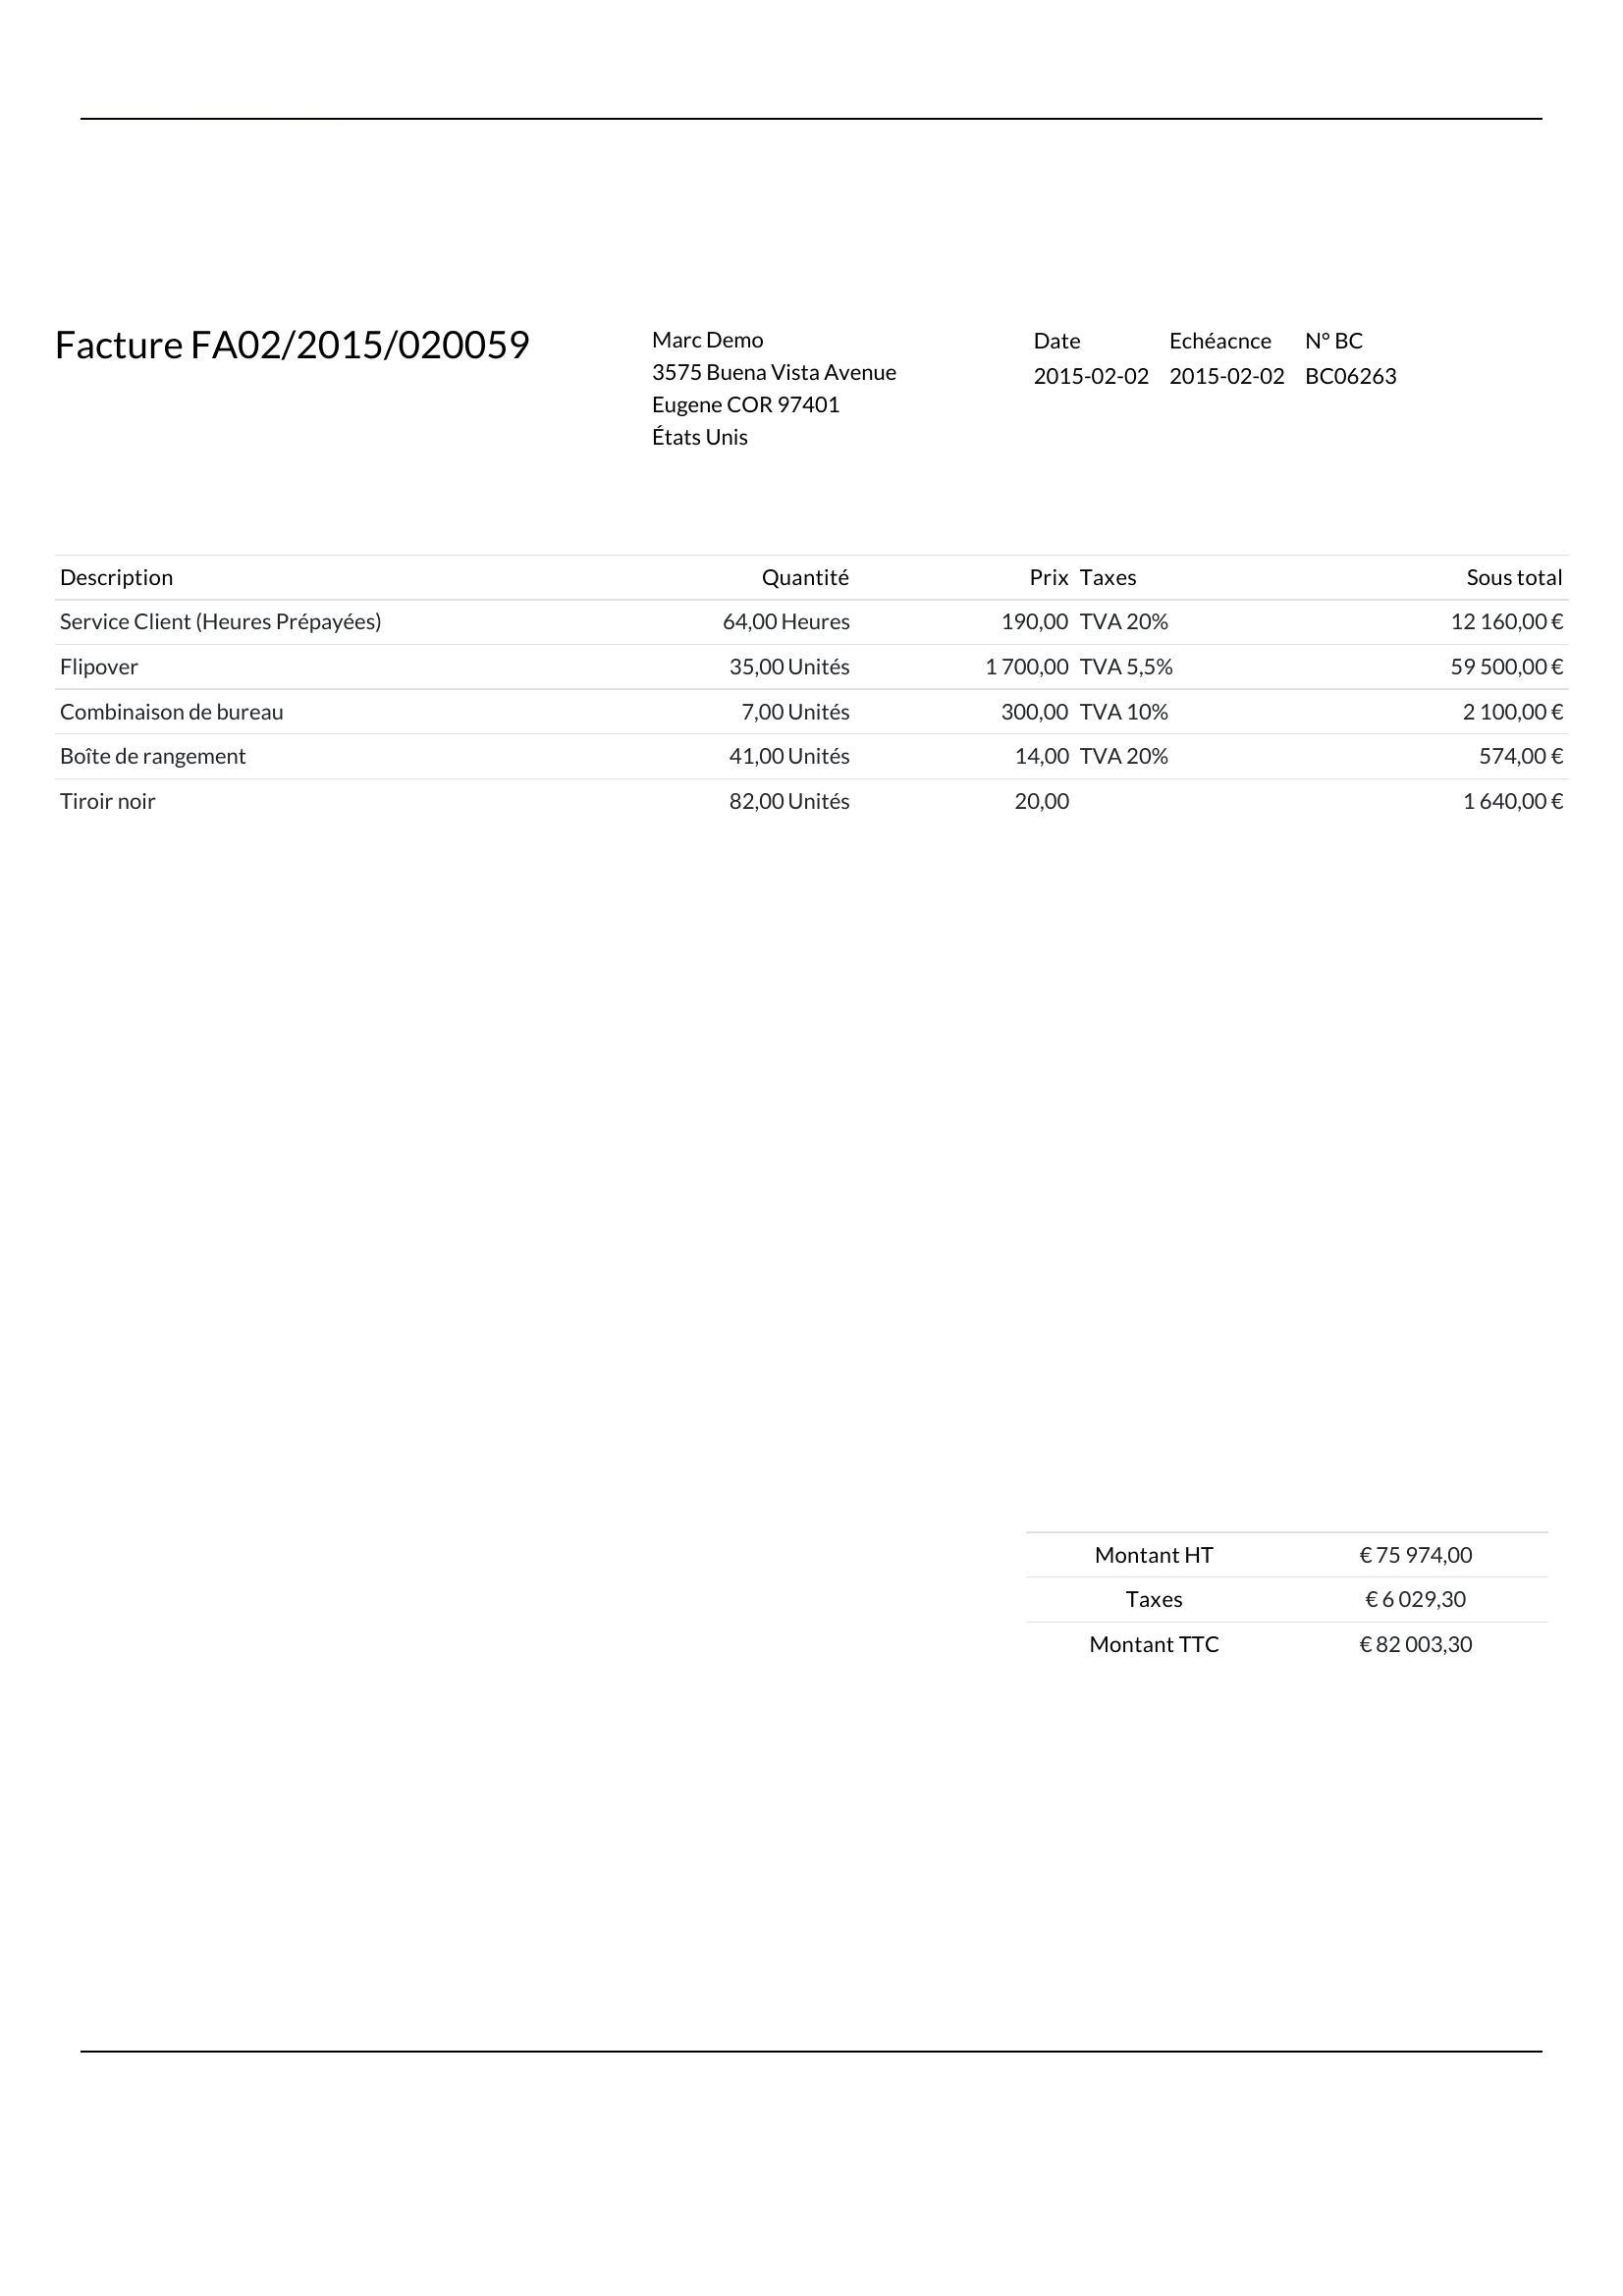

In [3]:
image = load_image("FACTU2015020048.jpg")
image

In [ ]:
# Initialize processor and model
model_id = "ibm-granite/granite-docling-258M"
processor = AutoProcessor.from_pretrained(model_id)
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    dtype=torch.bfloat16,
    # _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "sdpa",
).to(DEVICE)

In [5]:
# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Convert this page to docling."},
        ],
    },
]

In [6]:
# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="pt")
inputs = inputs.to(DEVICE)

In [7]:
prompt

'<|start_of_role|>user<|end_of_role|><image>Convert this page to docling.<|end_of_text|>\n<|start_of_role|>assistant<|end_of_role|>'

In [8]:
for k, v in inputs.items():
    print(f"{k}: {v.shape}")

pixel_values: torch.Size([1, 13, 3, 512, 512])
pixel_attention_mask: torch.Size([1, 13, 512, 512])
input_ids: torch.Size([1, 878])
attention_mask: torch.Size([1, 878])


In [9]:
with torch.no_grad():
    generated_ids = model.generate(
        **inputs,
        max_new_tokens=16,  # Limit token because the generation speed is slow
        pad_token_id=processor.tokenizer.eos_token_id,
    )

In [10]:
prompt_length = inputs.input_ids.shape[1]
trimmed_generated_ids = generated_ids[:, prompt_length:]
doctags = processor.batch_decode(
    trimmed_generated_ids,
    skip_special_tokens=False,
)[0].lstrip()

print(f"DocTags: \n{doctags}\n")

DocTags: 
<doctag><section_header_level_1><loc_17><loc_70><loc_164><loc



In [11]:
# Populate document
doctags_doc = DocTagsDocument.from_doctags_and_image_pairs([doctags], [image])
# create a docling document
doc = DoclingDocument.load_from_doctags(doctags_doc, document_name="Document")

In [12]:
print(f"Markdown:\n{doc.export_to_markdown()}\n")

Markdown:
## 



In [ ]:
## export as any format.
# Path("out/").mkdir(parents=True, exist_ok=True)
# HTML:
# output_path_html = Path("out/") / "example.html"
# doc.save_as_html(output_path_html)
# Markdown:
# output_path_md = Path("out/") / "example.md"
# doc.save_as_markdown(output_path_md)